# Running Palace Simulations

[Palace](https://awslabs.github.io/palace/) is an open-source 3D electromagnetic simulator supporting eigenmode, driven (S-parameter), and electrostatic simulations. This notebook demonstrates using the `gsim.palace` API to run a driven simulation on a CPW (coplanar waveguide) structure.

**Requirements:**

- IHP PDK: `uv pip install ihp-gdsfactory`
- [GDSFactory+](https://gdsfactory.com) account for cloud simulation

### Load a pcell from IHP PDK

2026-02-18 17:48:52.672 | WARNING  | doroutes.pcells:<module>:25 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to continue but likely this will fail.
2026-02-18 17:48:52.674 | WARNING  | doroutes.pcells:<module>:48 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to continue but likely this will fail.
2026-02-18 17:48:52.675 | WARNING  | doroutes.pcells:<module>:110 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to continue but likely this will fail.
2026-02-18 17:48:52.675 | WARNING  | doroutes.pcells:<module>:149 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to continue but likely this will fail.
2026-02-18 17:48:52.676 | WARNING  | doroutes.pcells:<module>:168 - Cannot determine output type ((D)KCell type)from annotation <class 'kfactory.kcell.DKCell'>. Trying to con

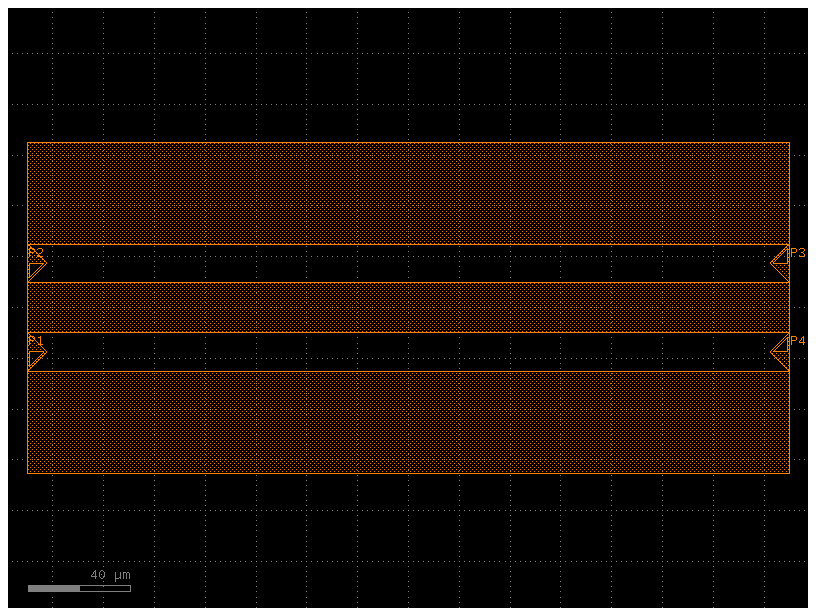

In [1]:
import gdsfactory as gf
from ihp import LAYER, PDK

PDK.activate()


@gf.cell
def gsg_electrode(
    length: float = 300,
    s_width: float = 20,
    g_width: float = 40,
    gap_width: float = 15,
    layer=LAYER.TopMetal2drawing,
) -> gf.Component:
    """
    Create a GSG (Ground-Signal-Ground) electrode.

    Args:
        length: horizontal length of the electrodes
        s_width: width of the signal (center) electrode
        g_width: width of the ground electrodes
        gap_width: gap between signal and ground electrodes
        layer: layer for the metal
    """
    c = gf.Component()

    # Top ground electrode
    r1 = c << gf.c.rectangle((length, g_width), centered=True, layer=layer)
    r1.move((0, (g_width + s_width) / 2 + gap_width))

    # Center signal electrode
    _r2 = c << gf.c.rectangle((length, s_width), centered=True, layer=layer)

    # Bottom ground electrode
    r3 = c << gf.c.rectangle((length, g_width), centered=True, layer=layer)
    r3.move((0, -(g_width + s_width) / 2 - gap_width))

    # Add ports at the gaps
    c.add_port(
        name="P1",
        center=(-length / 2, -(s_width + gap_width) / 2),
        width=gap_width,
        orientation=0,
        port_type="electrical",
        layer=layer,
    )

    c.add_port(
        name="P2",
        center=(-length / 2, (s_width + gap_width) / 2),
        width=gap_width,
        orientation=0,
        port_type="electrical",
        layer=layer,
    )

    c.add_port(
        name="P3",
        center=(length / 2, (s_width + gap_width) / 2),
        width=gap_width,
        orientation=180,
        port_type="electrical",
        layer=layer,
    )

    c.add_port(
        name="P4",
        center=(length / 2, -(s_width + gap_width) / 2),
        width=gap_width,
        orientation=180,
        port_type="electrical",
        layer=layer,
    )

    return c


c = gsg_electrode()
cc = c.copy()
cc.draw_ports()
cc

### Configure and run simulation with DrivenSim

In [2]:
from gsim.palace import DrivenSim

# Create simulation object
sim = DrivenSim()

# Set output directory
sim.set_output_dir("./palace-sim-cpw")

# Set the component geometry
sim.set_geometry(c)

# Configure layer stack from active PDK
sim.set_stack(substrate_thickness=2.0, air_above=300.0)

# Configure left CPW port (P1 lower, P2 upper)
sim.add_cpw_port("P2", "P1", layer="topmetal2", length=5.0)

# Configure right CPW port (P4 lower, P3 upper)
sim.add_cpw_port("P3", "P4", layer="topmetal2", length=5.0)

# Configure driven simulation (frequency sweep for S-parameters)
sim.set_driven(fmin=1e9, fmax=100e9, num_points=40)

# Validate configuration
print(sim.validate_config())

Validation: PASSED


In [3]:
# Generate mesh (presets: "coarse", "default", "fine")
sim.mesh(preset="default")

Mesh Summary
Dimensions: 500.0 x 330.0 x 416.6 µm
Nodes:      3,942
Elements:   31,230
Tetrahedra: 22,592
Edge length: 0.40 - 323.88 µm
Quality:    0.468 (min: 0.001)
SICN:       0.519 (all valid)
----------------------------------------
Volumes (4):
  - air [1]
  - passive [2]
  - SiO2 [3]
  - airbox [4]
Surfaces (7):
  - topmetal2_xy [5]
  - topmetal2_z [6]
  - P1_E0 [7]
  - P1_E1 [8]
  - P2_E0 [9]
  - P2_E1 [10]
  - Absorbing_boundary [11]
----------------------------------------
Mesh:   palace-sim-cpw/palace.msh

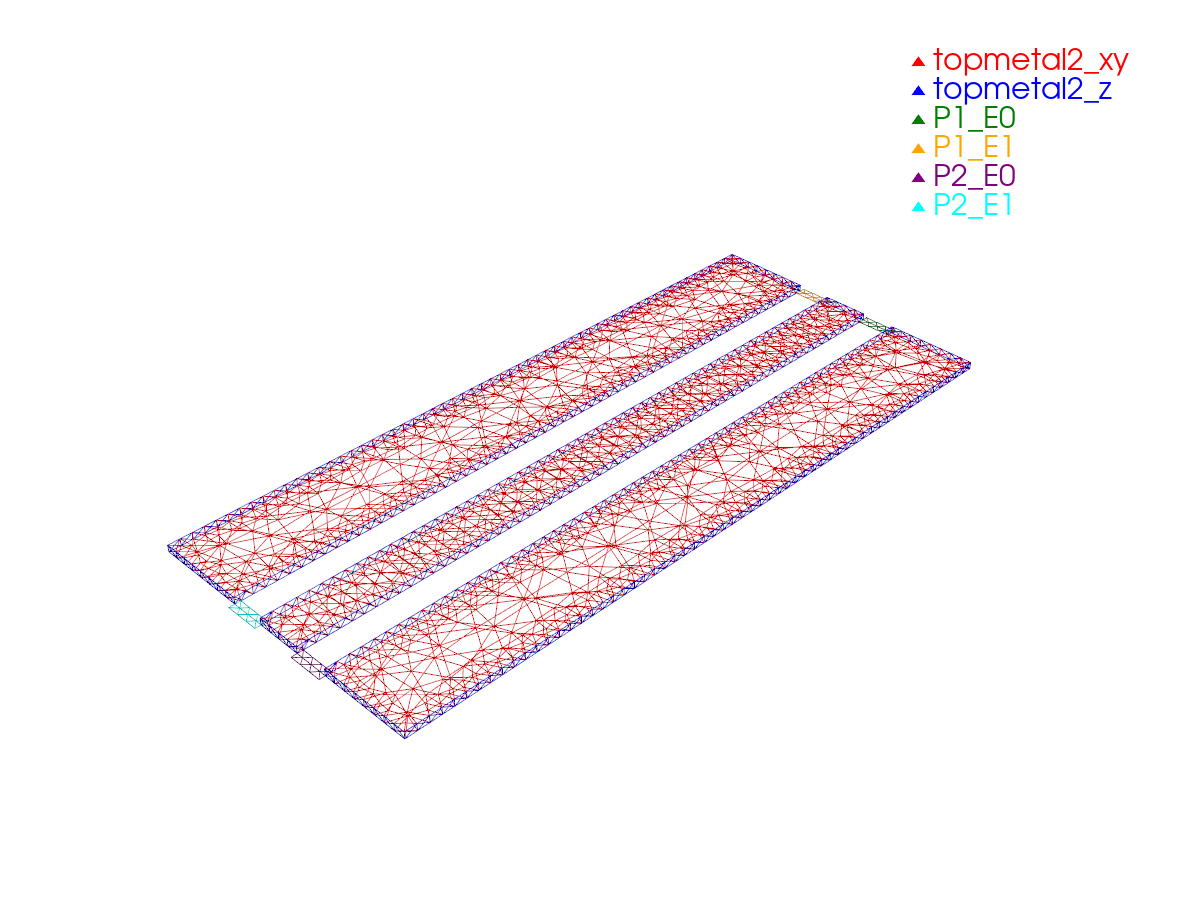

In [4]:
# Static PNG
sim.plot_mesh(show_groups=["metal", "P"], interactive=False)

# Interactive
# sim.plot_mesh(show_groups=["metal", "P"], interactive=True)

### Run simulation on cloud

In [ ]:
# Run simulation on GDSFactory+ cloud
results = sim.run()

# Run locally (requires local installation of Palace)
# results = sim.run_local()

>> /usr/lib64/mpich/bin/mpirun -n 1 /opt/palace/bin/palace-x86_64.bin config.json

_____________     _______
_____   __   \____ __   /____ ____________
____   /_/  /  __ ` /  /  __ ` /  ___/  _ \
___   _____/  /_/  /  /  /_/  /  /__/  ___/
  /__/     \___,__/__/\___,__/\_____\_____/

Git changeset ID: v0.14.0-305-g51d61b03
Running with 1 MPI process, 30 OpenMP threads
Device configuration: omp,cpu
Memory configuration: host-std
libCEED backend: /cpu/self/xsmm/blocked

Added 3344 boundary elements for material interfaces to the mesh
Finished partitioning mesh into 1 subdomain

Characteristic length and time scales:
 L₀ = 5.000e-04 m, t₀ = 1.668e-03 ns

Mesh curvature order: 1
Mesh bounding box:
 (Xmin, Ymin, Zmin) = (-2.500e-04, -1.650e-04, -5.200e-05) m
 (Xmax, Ymax, Zmax) = (+2.500e-04, +1.650e-04, +3.646e-04) m

Parallel Mesh Stats:

                minimum     average     maximum       total
 vertices          3942        3942        3942        3942
 edges            23781       23

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv(results["port-S.csv"])
df.columns = df.columns.str.strip()  # Remove whitespace from column names

freq = df["f (GHz)"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))

# Magnitude plot
ax1.plot(freq, df["|S[1][1]| (dB)"], marker=".", label="S11")
ax1.plot(freq, df["|S[2][1]| (dB)"], marker=".", label="S21")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_title("S-Parameters")
ax1.legend()
ax1.grid(True)

# Phase plot
ax2.plot(freq, df["arg(S[1][1]) (deg.)"], marker=".", label="S11")
ax2.plot(freq, df["arg(S[2][1]) (deg.)"], marker=".", label="S21")
ax2.set_xlabel("Frequency (GHz)")
ax2.set_ylabel("Phase (deg)")
ax2.legend()
ax2.grid(True)

plt.tight_layout()